# Capacitated Vehicle Routing Problem

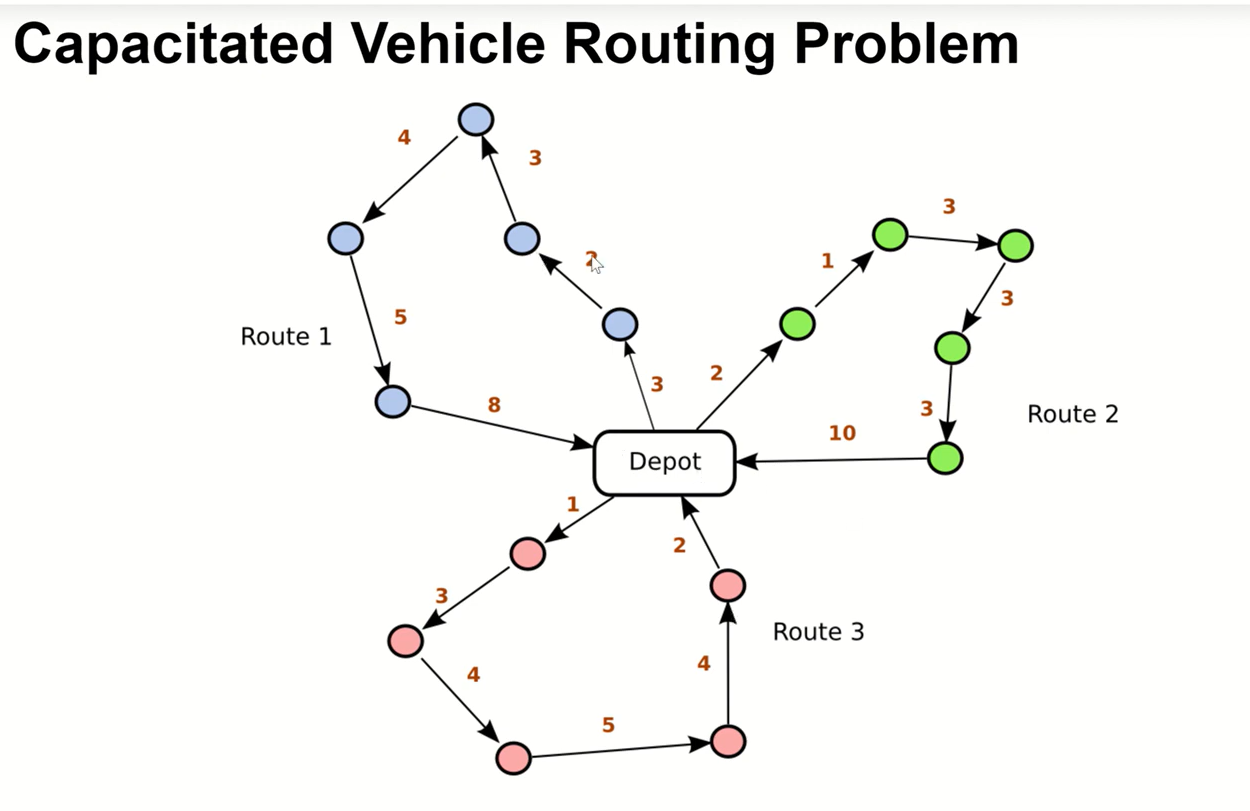

- $n$ is the number of clientes
- $N$ is set of clients, with $N=\{1,2,...,n\}$
- $V$ is set of vetices (or nodes), with $V=\{0\}\cup N$
- $A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$

Then, the formulation is the following
$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rnd = np.random
rnd.seed(0)

```random.seed(0)``` sets the seed for the random number generator in Python's random module to a fixed value of 0. This ensures that the sequence of "random" numbers generated by functions like ```random.random()``` or ```random.randint()``` will be the same every time the program runs . 

In [3]:
n = 20  # numbre of clients
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100

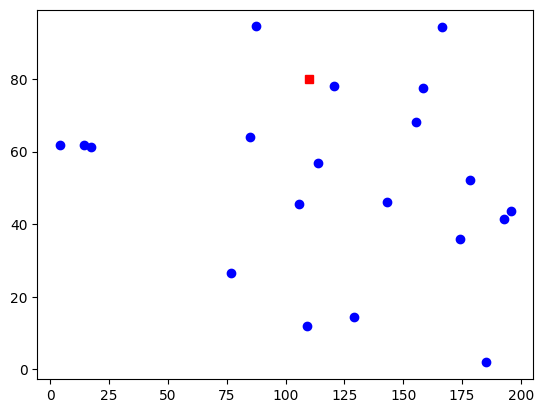

In [4]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b') #c- color, b- blue

In [7]:
N = [i for i in range(1, n+1)]
V = [0] + N #Union'+'
A = [(i, j) for i in V for j in V if i != j]

In [11]:
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}

What does this do?

- Creates a dictionary

- Keys → tuples (i, j)

- Values → Euclidean distance between node i and node j

```np.hypot(a, b)``` computes: $\sqrt{a^2 + b^2}$

- ```c[(i, j)]``` = **cost / distance** of traveling from node i to node j

In [12]:
Q = 20
q = {i: rnd.randint(1, 10) for i in N}

In [13]:
q

{1: 7,
 2: 1,
 3: 7,
 4: 4,
 5: 4,
 6: 9,
 7: 9,
 8: 9,
 9: 3,
 10: 4,
 11: 3,
 12: 1,
 13: 9,
 14: 9,
 15: 4,
 16: 9,
 17: 3,
 18: 9,
 19: 5,
 20: 4}

In [14]:
from gurobipy import Model, GRB, quicksum

In [16]:
mdl = Model('CVRP') # Built a model named CVRP

In [17]:
x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)

Above creates a binary variable for each arc (i, j) ∈ A

- Stored in a dictionary-like object x
- ```x[i, j] = 1``` → vehicle travels directly from node ```i to node j```
- ```x[i, j] = 0``` → vehicle does NOT travel from ```i to j```

In [20]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

In [21]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i != 0 and j != 0)
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[i] <= Q for i in N)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>}

In [22]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 30  # seconds

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 30


#### What is MIPGap?

- Applies to **Mixed Integer Programming (MIP)** problems (like CVRP)
- Measures how close the current solution is to the **best possible (optimal) solution**

#### MIPGap Formula

$$
\text{MIPGap} =
\frac{\text{Best Objective} - \text{Best Bound}}
{|\text{Best Objective}|}
$$


#### What does `0.1` mean?

- `0.1` = **10% optimality gap**
- Gurobi will **stop early** if it finds a solution within **10% of optimal**

#### Trade-off

-  Faster solution  
-  May not be perfectly optimal


mdl.optimize()

In [24]:
active_arcs = [a for a in A if x[a].x > 0.99]  ## it is x==1, but for some calculation reasons take x>0.99

In [25]:
active_arcs

[(0, 2),
 (0, 3),
 (0, 4),
 (0, 7),
 (0, 14),
 (0, 19),
 (1, 11),
 (2, 18),
 (3, 5),
 (4, 9),
 (5, 13),
 (6, 0),
 (7, 1),
 (8, 20),
 (9, 15),
 (10, 17),
 (11, 12),
 (12, 0),
 (13, 0),
 (14, 16),
 (15, 6),
 (16, 0),
 (17, 0),
 (18, 10),
 (19, 8),
 (20, 0)]

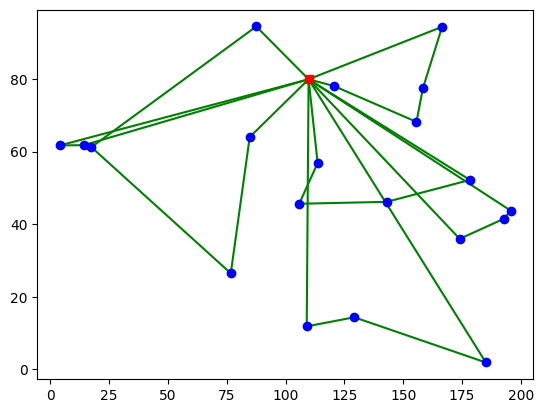

In [26]:
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

#### Conclusion : 
- Best objective:  **1.222825303171e+03**
- Best bound: **8.910758317369e+02**
- Gap: **27.1298%**